## Importing Required Libraries

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

## Set EDA Style

In [20]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

## Connection to Database

In [3]:
db_path = Path.cwd(). parent / "inventory.db"

In [6]:
conn = sqlite3.connect(db_path)
query = """
SELECT 
    t.Invoice, 
    t.StockCode, 
    p.Description, 
    t.Quantity, 
    t.Price, 
    (t.Quantity*t.Price) as TotalAmount,
    t.InvoiceDate,
    t.[Customer ID]
FROM transactions t
LEFT JOIN products p ON t.StockCode = p.StockCode
"""

df = pd.read_sql(query, conn)
conn.close()

df.head()

,Invoice,StockCode,Description,Quantity,Price,TotalAmount,InvoiceDate,Customer ID
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95,83.4,2009-12-01 07:45:00,13085.0
1,489434,79323P,PINK CHERRY LIGHTS,12,6.75,81.0,2009-12-01 07:45:00,13085.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,6.75,81.0,2009-12-01 07:45:00,13085.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2.10,100.8,2009-12-01 07:45:00,13085.0
4,489434,21232,STRAWBERRY CERAMIC TRINKET POT,24,1.25,30.0,2009-12-01 07:45:00,13085.0


## Data Cleaning, EDA, and Insights

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824364 entries, 0 to 824363
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      824364 non-null  object 
 1   StockCode    824364 non-null  object 
 2   Description  824364 non-null  object 
 3   Quantity     824364 non-null  int64  
 4   Price        824364 non-null  float64
 5   TotalAmount  824364 non-null  float64
 6   InvoiceDate  824364 non-null  object 
 7   Customer ID  824364 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 50.3+ MB


In [8]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824364 entries, 0 to 824363
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      824364 non-null  object        
 1   StockCode    824364 non-null  object        
 2   Description  824364 non-null  object        
 3   Quantity     824364 non-null  int64         
 4   Price        824364 non-null  float64       
 5   TotalAmount  824364 non-null  float64       
 6   InvoiceDate  824364 non-null  datetime64[ns]
 7   Customer ID  824364 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 50.3+ MB


In [9]:
df.describe()

,Quantity,Price,TotalAmount,InvoiceDate,Customer ID
count,824364.000000,824364.000000,824364.000000,824364,824364.000000
mean,12.414574,3.676800,20.195317,2011-01-01 22:29:28.042054144,15324.638504
min,-80995.000000,0.000000,-168469.600000,2009-12-01 07:45:00,12346.000000
25%,2.000000,1.250000,4.250000,2010-07-06 11:58:00,13975.000000
50%,5.000000,1.950000,11.250000,2010-12-03 14:26:00,15255.000000
75%,12.000000,3.750000,19.500000,2011-07-27 15:14:00,16797.000000
max,80995.000000,38970.000000,168469.600000,2011-12-09 12:50:00,18287.000000
std,188.976099,70.241388,308.685001,NaN,1697.464450


In [10]:
df_sales = df[df['Quantity'] > 0].copy()
df_returns = df[df['Quantity'] < 0].copy()

print(f"Sales shape: {df_sales.shape}")
print(f"Returns shape: {df_returns.shape}")

Sales shape: (805620, 8)
Returns shape: (18744, 8)


C:\Users\HP\AppData\Local\Temp\ipykernel_14412\2337761118.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df_sales.set_index('InvoiceDate').resample('M')['TotalAmount'].sum()


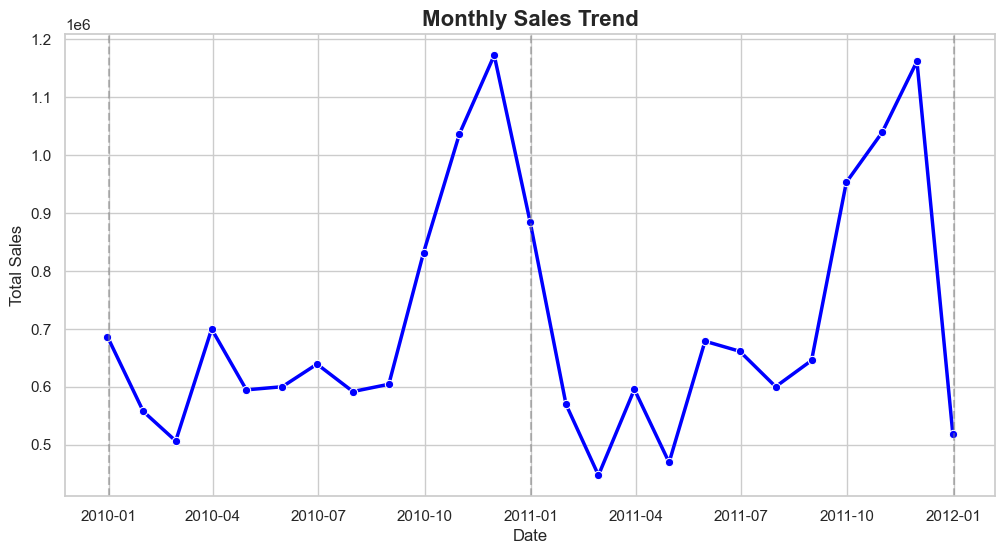

In [21]:
monthly_sales = df_sales.set_index('InvoiceDate').resample('M')['TotalAmount'].sum()

sns.lineplot(data=monthly_sales, marker='o', color='blue', linewidth=2.5)

plt.title("Monthly Sales Trend", fontsize=16, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Total Sales")

plt.axvline(pd.Timestamp('2010-01-01'), color='gray', linestyle='--', alpha=0.5)
plt.axvline(pd.Timestamp('2011-01-01'), color='gray', linestyle='--', alpha=0.5)
plt.axvline(pd.Timestamp('2012-01-01'), color='gray', linestyle='--', alpha=0.5)


plt.show()

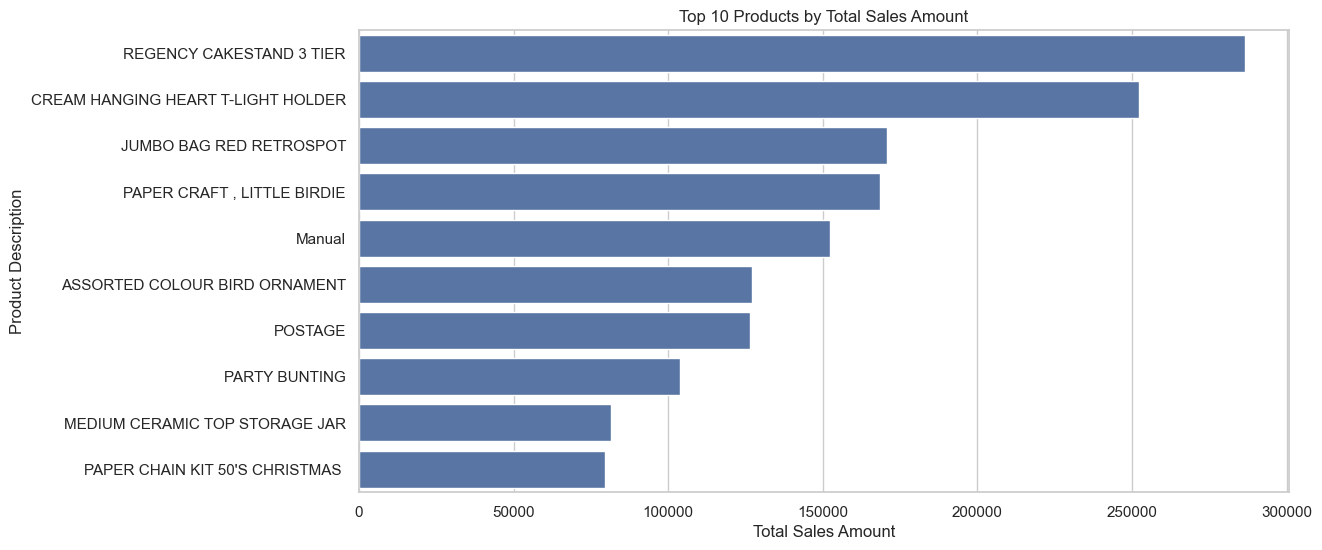

In [22]:
top_products = df_sales.groupby('Description')['TotalAmount'].sum().sort_values(ascending=False).head(10)

sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 10 Products by Total Sales Amount')
plt.xlabel('Total Sales Amount')
plt.ylabel('Product Description')
plt.show()

Top 5 Customers
Customer ID
18102.0    608821.65
14646.0    528602.52
14156.0    313946.37
14911.0    295972.63
17450.0    246973.09
Name: TotalAmount, dtype: float64


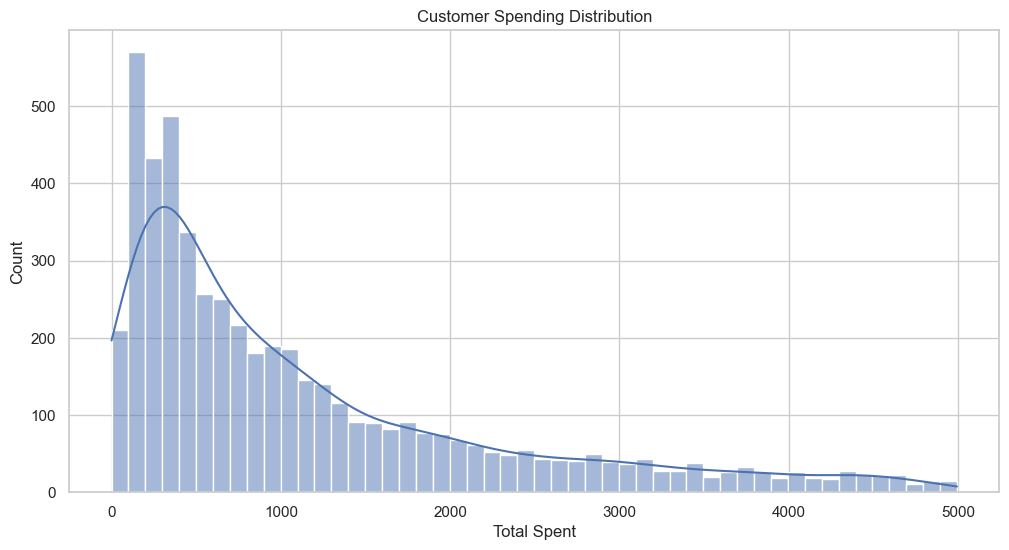

In [27]:
customer_sales = df_sales.groupby('Customer ID')['TotalAmount'].sum().sort_values(ascending=False)

print("Top 5 Customers")
print(customer_sales.head())
sns.histplot(customer_sales[customer_sales < 5000], kde=True, bins=50)
plt.title("Customer Spending Distribution")
plt.xlabel("Total Spent")
plt.show()